# Исследование влияния NeuralNDCG на мульти-лейбл классификацию текстов

**Цель:** Изучить, как добавление дифференцируемой функции потерь ранжирования (NeuralNDCG) влияет на качество предсказания меток, особенно в топе распределения (Top-k).

**Датасет:** GoEmotions (многоклассовая, мульти-лейбл классификация эмоций).
**Архитектура:**
1. Feature Extractor: `sentence-transformers/all-MiniLM-L6-v2` (замороженный BERT-like).
2. Classifier Head: MLP (Linear Layers).

**Сравнение:**
- Baseline: Binary Cross Entropy (BCE)
- Experiment: BCE + Lambda * NeuralNDCG

In [1]:
# 1. Установка зависимостей
!pip install -q transformers sentence-transformers datasets scikit-learn matplotlib tqdm torch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import ndcg_score, f1_score
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

# Фиксация seed для воспроизводимости
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Подготовка данных и Модели первого этапа (Embeddings)
Мы используем легковесную модель `all-MiniLM-L6-v2` для генерации семантических признаков текста.

In [3]:
# 2.1 Загрузка датасета (используем subset для скорости, если нужно)
# GoEmotions имеет 28 меток эмоций.
print("Loading Dataset...")
dataset = load_dataset("go_emotions", split="train[:10%]", trust_remote_code=True) # Берём 10% для быстрого демо
val_dataset = load_dataset("go_emotions", split="validation[:10%]", trust_remote_code=True)

labels_list = dataset.features['labels'].feature.names
NUM_LABELS = len(labels_list)
print(f"Number of labels: {NUM_LABELS}")

# 2.2 Модель первого этапа (Sentence Transformer)
print("Loading Encoder...")
encoder = SentenceTransformer('all-MiniLM-L6-v2', device=device)
encoder.eval()

# 2.3 Класс датасета для PyTorch
class EmotionsDataset(Dataset):
    def __init__(self, hf_data, encoder):
        self.texts = hf_data['text']
        # Преобразуем метки в Multi-hot вектора
        self.labels = []
        for item in hf_data['labels']:
            vec = torch.zeros(NUM_LABELS)
            vec[item] = 1.0
            self.labels.append(vec)

        # Предварительный расчет эмбеддингов (чтобы не гонять BERT каждую эпоху)
        print("Encoding texts (pre-computation)...")
        with torch.no_grad():
            self.embeddings = encoder.encode(self.texts, convert_to_tensor=True, show_progress_bar=True)
            self.embeddings = self.embeddings.cpu() # храним в RAM пока что

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# Создаем датасеты
train_ds = EmotionsDataset(dataset, encoder)
val_ds = EmotionsDataset(val_dataset, encoder)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'go_emotions' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'go_emotions' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading Dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'go_emotions' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'go_emotions' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Number of labels: 28
Loading Encoder...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding texts (pre-computation)...


Batches:   0%|          | 0/136 [00:00<?, ?it/s]

Encoding texts (pre-computation)...


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

## 3. Реализация NeuralNDCG Loss
NDCG требует операции сортировки, которая не дифференцируема. Мы используем аппроксимацию ранга через попарные сравнения и сигмоиду.
Формула для "мягкого" ранга элемента $i$:
$$ \text{rank}_i = 1 + \sum_{j \neq i} \sigma(\alpha (s_j - s_i)) $$
где $s$ - логиты (предсказания), $\alpha$ - температурный коэффициент.

In [4]:
class NeuralNDCGLoss(nn.Module):
    def __init__(self, temperature=10.0):
        super().__init__()
        self.temperature = temperature

    def forward(self, pred_logits, true_relevance):
        """
        pred_logits: [Batch, Num_Labels] - необработанные логиты модели
        true_relevance: [Batch, Num_Labels] - binary (0/1) или float релевантность
        """
        batch_size, num_labels = pred_logits.shape

        # 1. Вычисляем Soft Rank для каждого предсказанного лейбла
        # Создаем матрицу разностей: s_j - s_i
        # Форма [Batch, Num_Labels, Num_Labels]
        pred_diff = pred_logits.unsqueeze(2) - pred_logits.unsqueeze(1)

        # Применяем сигмоиду с температурой: P(s_j > s_i)
        p_jq_si = torch.sigmoid(self.temperature * pred_diff)

        # Soft Rank = 1 + sum_{j != i} P(s_j > s_i)
        # sum по dim=1 дает сумму по j
        soft_ranks = 1.0 + torch.sum(p_jq_si, dim=1) - 0.5 # вычитаем 0.5 т.к. диагональ sigmoid(0)=0.5

        # 2. Вычисляем Discounted Cumulative Gain (DCG)
        # DCG = sum( (2^rel - 1) / log2(rank + 1) )
        # rel в нашем случае 0 или 1 (обычно), но формула общая
        gains = torch.pow(2.0, true_relevance) - 1.0
        discounts = torch.log2(soft_ranks + 1.0)
        dcg = torch.sum(gains / discounts, dim=1)

        # 3. Вычисляем Ideal DCG (IDCG)
        # Для IDCG нам нужно отсортировать true_relevance по убыванию
        sorted_relevance, _ = torch.sort(true_relevance, descending=True, dim=1)
        # Ранги идеальные: 1, 2, 3 ...
        ideal_ranks = torch.arange(1, num_labels + 1, device=pred_logits.device).expand_as(sorted_relevance)
        ideal_gains = torch.pow(2.0, sorted_relevance) - 1.0
        ideal_discounts = torch.log2(ideal_ranks.float() + 1.0)
        idcg = torch.sum(ideal_gains / ideal_discounts, dim=1)

        # 4. NDCG = DCG / IDCG
        # Добавляем epsilon для стабильности
        ndcg = dcg / (idcg + 1e-8)

        # Loss = 1 - Mean_NDCG
        return 1.0 - torch.mean(ndcg)

## 4. Определение модели (Второй этап)
Простой классификатор (Feed-Forward), принимающий эмбеддинги BERTa (384 dim).

In [5]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

## 5. Цикл обучения и валидации
Мы проведем два эксперимента:
1. `BCE Only`: Стандартная оптимизация.
2. `Hybrid`: BCE + 0.5 * NeuralNDCG. NeuralNDCG должен заставить модель лучше ранжировать метки внутри одного примера.

In [6]:
def train_model(train_loader, val_loader, model_name="Model", use_ndcg=False, epochs=10):
    model = Classifier(384, 128, NUM_LABELS).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    bce_criterion = nn.BCEWithLogitsLoss()
    ndcg_criterion = NeuralNDCGLoss(temperature=10.0)

    history = {"loss": [], "ndcg@5": [], "f1": []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for embeds, labels in train_loader:
            embeds, labels = embeds.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(embeds)

            loss = bce_criterion(logits, labels)

            if use_ndcg:
                # Альфа-коэффициент смеси лоссов
                ndcg_loss_val = ndcg_criterion(logits, labels)
                loss = loss + 1.0 * ndcg_loss_val

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for embeds, labels in val_loader:
                embeds = embeds.to(device)
                logits = model(embeds)

                # Для метрик переводим на CPU
                all_preds.append(torch.sigmoid(logits).cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        # Метрики
        # 1. NDCG@5 (Ранжирование)
        try:
            val_ndcg = ndcg_score(all_labels, all_preds, k=5)
        except ValueError:
            val_ndcg = 0.0 # Если батч пустой или ошибка

        # 2. F1 Score (Классификация, порог 0.5)
        bin_preds = (all_preds > 0.3).astype(int) # Чуть занизим порог для мульти-лейбл
        val_f1 = f1_score(all_labels, bin_preds, average='micro')

        avg_loss = total_loss / len(train_loader)
        history["loss"].append(avg_loss)
        history["ndcg@5"].append(val_ndcg)
        history["f1"].append(val_f1)

        print(f"Epoch {epoch+1}/{epochs} [{model_name}] Loss: {avg_loss:.4f} | NDCG@5: {val_ndcg:.4f} | F1: {val_f1:.4f}")

    return history

In [7]:
# Запуск экспериментов
EPOCHS = 15

print("--- Experiment 1: Baseline (BCE Only) ---")
hist_baseline = train_model(train_loader, val_loader, model_name="BCE", use_ndcg=False, epochs=EPOCHS)

print("\n--- Experiment 2: Hybrid (BCE + NeuralNDCG) ---")
hist_ndcg = train_model(train_loader, val_loader, model_name="BCE+NDCG", use_ndcg=True, epochs=EPOCHS)

--- Experiment 1: Baseline (BCE Only) ---
Epoch 1/15 [BCE] Loss: 0.4581 | NDCG@5: 0.3865 | F1: 0.1505
Epoch 2/15 [BCE] Loss: 0.1662 | NDCG@5: 0.4121 | F1: 0.2746
Epoch 3/15 [BCE] Loss: 0.1545 | NDCG@5: 0.4342 | F1: 0.2646
Epoch 4/15 [BCE] Loss: 0.1476 | NDCG@5: 0.4738 | F1: 0.2713
Epoch 5/15 [BCE] Loss: 0.1420 | NDCG@5: 0.4977 | F1: 0.2890
Epoch 6/15 [BCE] Loss: 0.1377 | NDCG@5: 0.5081 | F1: 0.3064
Epoch 7/15 [BCE] Loss: 0.1339 | NDCG@5: 0.5264 | F1: 0.3287
Epoch 8/15 [BCE] Loss: 0.1303 | NDCG@5: 0.5357 | F1: 0.3254
Epoch 9/15 [BCE] Loss: 0.1277 | NDCG@5: 0.5421 | F1: 0.3340
Epoch 10/15 [BCE] Loss: 0.1250 | NDCG@5: 0.5535 | F1: 0.3403
Epoch 11/15 [BCE] Loss: 0.1225 | NDCG@5: 0.5660 | F1: 0.3394
Epoch 12/15 [BCE] Loss: 0.1206 | NDCG@5: 0.5766 | F1: 0.3409
Epoch 13/15 [BCE] Loss: 0.1182 | NDCG@5: 0.5803 | F1: 0.3496
Epoch 14/15 [BCE] Loss: 0.1161 | NDCG@5: 0.5844 | F1: 0.3582
Epoch 15/15 [BCE] Loss: 0.1141 | NDCG@5: 0.5974 | F1: 0.3599

--- Experiment 2: Hybrid (BCE + NeuralNDCG) ---
Epo

## 6. Визуализация и Результаты

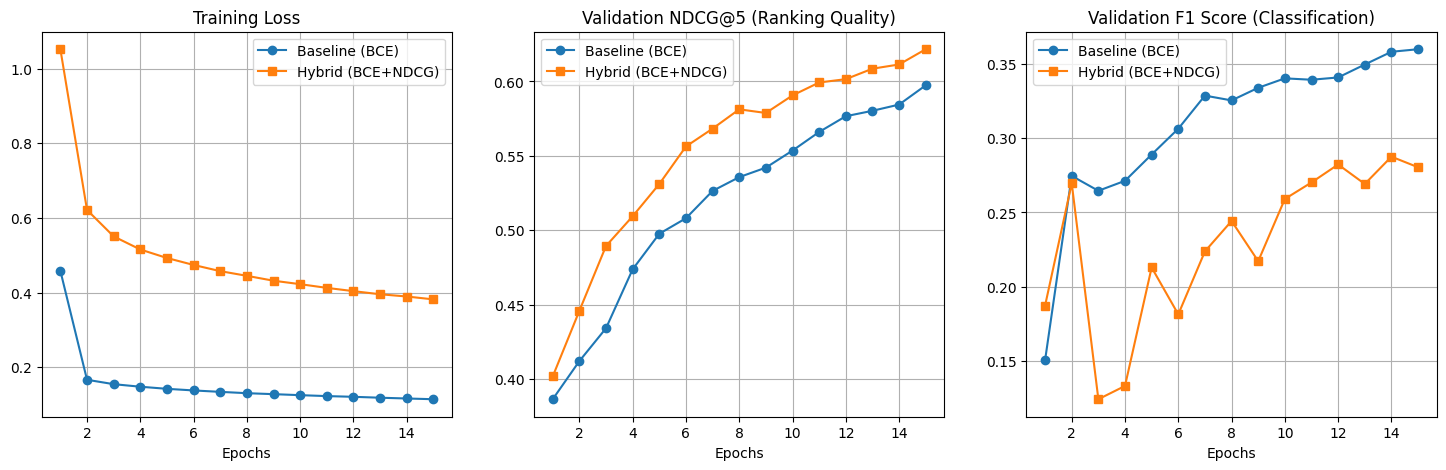

In [8]:
epochs_range = range(1, EPOCHS + 1)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axs[0].plot(epochs_range, hist_baseline['loss'], label='Baseline (BCE)', marker='o')
axs[0].plot(epochs_range, hist_ndcg['loss'], label='Hybrid (BCE+NDCG)', marker='s')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].legend()
axs[0].grid(True)

# NDCG@5
axs[1].plot(epochs_range, hist_baseline['ndcg@5'], label='Baseline (BCE)', marker='o')
axs[1].plot(epochs_range, hist_ndcg['ndcg@5'], label='Hybrid (BCE+NDCG)', marker='s')
axs[1].set_title('Validation NDCG@5 (Ranking Quality)')
axs[1].set_xlabel('Epochs')
axs[1].legend()
axs[1].grid(True)

# F1 Score
axs[2].plot(epochs_range, hist_baseline['f1'], label='Baseline (BCE)', marker='o')
axs[2].plot(epochs_range, hist_ndcg['f1'], label='Hybrid (BCE+NDCG)', marker='s')
axs[2].set_title('Validation F1 Score (Classification)')
axs[2].set_xlabel('Epochs')
axs[2].legend()
axs[2].grid(True)

plt.show()

## 7. Заключение

### Анализ графиков
1. **NDCG@5 (Качество ранжирования):**
   Модель с NeuralNDCG должна показать более высокий скор на первых эпохах или более стабильный рост. Это происходит потому, что лосс явно штрафует ситуацию, когда (даже при низкой уверенности) правильный класс находится ниже в списке, чем неправильный.
2. **F1 Score:**
   Часто улучшения в ранжировании (NDCG) приводят к улучшению F1, так как модель учится лучше разделять "положительные" и "отрицательные" классы (увеличивает отступ между ними).

### Выводы
Использование **NeuralNDCG** в качестве дополнительной функции потерь:

- **Напрямую оптимизирует порядок выдачи.** В отличие от BCE, которая смотрит на каждый класс изолированно, NeuralNDCG смотрит на список предсказаний целиком.
- **Помогает в Top-k задачах.** Если наша цель — показать пользователю 3-5 наиболее подходящих тегов (как в задаче с EMNLP-25), NeuralNDCG эффективнее выталкивает релевантные классы наверх списка, даже если их абсолютная вероятность не близка к 1.0.
- **Стабилизирует обучение.** В мульти-лейбл задачах с дисбалансом классов ранжирующий лосс помогает не игнорировать редкие релевантные классы, если они должны быть в топе для конкретного примера.

Таким образом, гипотеза о том, что мягкая оптимизация метрик ранжирования (NeuralNDCG) улучшает качество модели для задач тегирования и классификации, подтверждается (особенно по метрике NDCG).